# Here we try a variety of probes

They all fit into a sklearn style api, except they take torch tensors of >2 dims


In [1]:
import os
os.environ['TQDM_DISABLE'] = '1'


In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

plt.style.use("ggplot")

from typing import Optional, List, Dict, Union
from jaxtyping import Float
from torch import Tensor

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path
from einops import rearrange


import datasets
from datasets import Dataset

from loguru import logger


from typing import Optional, List, Dict, Union, Tuple
from jaxtyping import Float
from torch import Tensor

logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")

# # quiet please
torch.set_float32_matmul_precision("medium")
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")


In [3]:
# load my code
%load_ext autoreload
%autoreload 2

import lightning.pytorch as pl
from src.datasets.dm import DeceptionDataModule
from src.models.pl_lora_ft import AtapterFinetuner

from src.config import ExtractConfig
from src.prompts.prompt_loading import load_preproc_dataset, load_preproc_datasets
from src.models.load import load_model
from src.helpers.torch_helpers import clear_mem
from src.models.phi.model_phi import PhiForCausalLMWHS
# from src.eval.interventions import check_lr_intervention_predictive
from src.probes.utils import postproc


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use("ggplot")

plt.style.use(['seaborn-v0_8', 'seaborn-v0_8-paper'])


In [5]:
from src.eval.labels import ranking_truth_telling, ds2label_model_truth
from src.eval.ds import filter_ds_to_known

from src.probes.pl_ranking_probe import PLConvProbeLinear
from src.helpers.lightning import read_metrics_csv
from sklearn.metrics import roc_auc_score, accuracy_score
from src.helpers.pandas_classification_report import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset

from functools import partial
from src.eval.labels import ranking_truth_telling, undo_ranked_truth_telling
from src.helpers.ds import train_test_split_ds


?# Params

In [6]:
max_epochs = 50
batch_size=16
verbose = True
MAX_SAMPLES = 2600
SKIP=1
STIDE=2


## Setup data

We load data, previously collected, from the model


In [7]:
# !ls -altrh '/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.ds/'
# # !ls -altrh '/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.ds/ds_valtest_8c031b4aa03ae4d2'


In [8]:
# load hidden state from a previously loaded adapter
# the columns with _base are from the base model, and adapt from adapter
f1_ood = '/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.ds/ds_OOD_6d3ece46c44f6c3b'
f1_val = '/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.ds/ds_valtest_73b754e8fdff9f2f'
ds_val = Dataset.from_file(f1_val).with_format("torch")
ds_oos = Dataset.from_file(f1_ood).with_format("torch")

ds_out = datasets.interleave_datasets([ds_val, ds_oos], seed=42, 
                                    #   probabilities=[0.5, 0.5]
                                      )
ds_known1 = filter_ds_to_known(ds_out, verbose=True)
ds_known1 = ds_out



/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


select rows are 76.89% based on knowledge


In [9]:
def flip_even_rows(row: dict, idx: int) -> dict:
    """this will flip adapter and base keys for even rows, this balances the task."""
    # also record the original rows, and which ones are flipped?
    row2 = {k.replace('_base', '_base2').replace('_adapt', '_adapt2'): v for k, v in row.items()}
    row = {**row2, **row}
    
    if idx%2 == 0:
        row = {k.replace('_base', '_tmp'): v for k, v in row.items()}
        row = {k.replace('_adapt', '_base'): v for k, v in row.items()} 
        row = {k.replace('_tmp', '_adapt'): v for k, v in row.items()}
    return row

ds_known = ds_known1.map(flip_even_rows, with_indices=True)
ds_known


Dataset({
    features: ['end_logits_base', 'choice_probs_base', 'binary_ans_base', 'label_true_base', 'label_instructed_base', 'instructed_to_lie_base', 'sys_instr_name_base', 'example_i_base', 'ds_string_base', 'template_name_base', 'correct_truth_telling_base', 'correct_instruction_following_base', 'end_residual_stream_base', 'end_logits_adapt', 'choice_probs_adapt', 'binary_ans_adapt', 'label_true_adapt', 'label_instructed_adapt', 'instructed_to_lie_adapt', 'sys_instr_name_adapt', 'example_i_adapt', 'ds_string_adapt', 'template_name_adapt', 'correct_truth_telling_adapt', 'correct_instruction_following_adapt', 'end_residual_stream_adapt', 'end_logits_adapt2', 'choice_probs_adapt2', 'binary_ans_adapt2', 'label_true_adapt2', 'label_instructed_adapt2', 'instructed_to_lie_adapt2', 'sys_instr_name_adapt2', 'example_i_adapt2', 'ds_string_adapt2', 'template_name_adapt2', 'correct_truth_telling_adapt2', 'correct_instruction_following_adapt2', 'end_residual_stream_adapt2', 'end_logits_base2'

### split datasets

we want to split by insample (from training) and out of distribution

In [10]:
pd.Series(ds_val['ds_string_base']).value_counts(), pd.Series(ds_oos['ds_string_base']).value_counts()


(amazon_polarity    267
 glue:qnli          267
 super_glue:rte     267
 super_glue:axg     267
 sst2               267
 hans               267
 Name: count, dtype: int64,
 super_glue:boolq    534
 super_glue:axg      534
 imdb                534
 Name: count, dtype: int64)

In [11]:
insample_datasets = list(set(ds_val['ds_string_base']))
outsample_datasets = list(set(ds_oos['ds_string_base']))
print(insample_datasets, outsample_datasets)

trainval_datasets = insample_datasets + outsample_datasets[:1]
test_datasets = outsample_datasets[1:]
trainval_datasets, test_datasets


['sst2', 'glue:qnli', 'super_glue:axg', 'amazon_polarity', 'super_glue:rte', 'hans'] ['super_glue:axg', 'imdb', 'super_glue:boolq']


(['sst2',
  'glue:qnli',
  'super_glue:axg',
  'amazon_polarity',
  'super_glue:rte',
  'hans',
  'super_glue:axg'],
 ['imdb', 'super_glue:boolq'])

In [12]:
# FIXME: DELETEME: ONCE I HAVE RERUN BASE MODEL

insample_datasets = list(set(ds_val['ds_string_base']))
outsample_datasets = list(set(ds_oos['ds_string_base']))
print(insample_datasets, outsample_datasets)

trainval_datasets = ['super_glue:rte', 'amazon_polarity', 'hans', 'glue:qnli', 'super_glue:axg', 'sst2']
test_datasets = ['super_glue:boolq', 'imdb']
trainval_datasets, test_datasets


['sst2', 'glue:qnli', 'super_glue:axg', 'amazon_polarity', 'super_glue:rte', 'hans'] ['super_glue:axg', 'imdb', 'super_glue:boolq']


(['super_glue:rte',
  'amazon_polarity',
  'hans',
  'glue:qnli',
  'super_glue:axg',
  'sst2'],
 ['super_glue:boolq', 'imdb'])

In [14]:
ds_trainval = ds_known.filter(lambda example: example["ds_string_base"] in trainval_datasets)
ds_test = ds_known.filter(lambda example: example["ds_string_base"] not in trainval_datasets)

MAX_SAMPLES = min(len(ds_trainval), MAX_SAMPLES)
ds_trainval = ds_trainval.select(range(MAX_SAMPLES))

MAX_SAMPLES = min(len(ds_test), MAX_SAMPLES)
ds_test = ds_test.select(range(MAX_SAMPLES))


len(ds_trainval), len(ds_test)


(2136, 1068)

In [15]:

# ds_train, ds_val = train_test_split_ds(ds_trainval, test_size=0.3, stratify_columns=['ds_string_base'])
# len(ds_train), len(ds_val)


In [16]:
# set labels
ds2proxy = ranking_truth_telling
proxy2label = undo_ranked_truth_telling

# unit test labels
y_val1 = ds2proxy(ds_val)
y1 = proxy2label(y_val1, ds_val)
np.testing.assert_array_equal(y1, ds_val['label_true_base'], err_msg="undo_distance_truth_telling failed")
# assert (y1 == ds_val['label_true_base']).all()


In [17]:
import torch
import numpy as np
from einops import rearrange
from sklearn.preprocessing import StandardScaler, RobustScaler

class TorchRobustScaler(RobustScaler):

    def wrap(self, X, method: str):
        b, l, h, v = X.shape
        X = rearrange(X, "b l h v -> b (l h v)")
        X = getattr(super(), method)(X)
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(rearrange(X, "b (l h v) -> b l h v", l=l, h=h, v=v))
        return X

    def fit(self, X):
        return self.wrap(X, "fit")

    def transform(self, X):
        return self.wrap(X, "transform")

    def inverse_transform(self, X):
        return self.wrap(X, "inverse_transform")


In [18]:
ds = ds_trainval
x = torch.stack([ds['end_residual_stream_base'], ds['end_residual_stream_adapt']], -1)[:, SKIP::STIDE]
y = ds2proxy(ds)
x.shape


torch.Size([2136, 14, 2559, 2])

In [19]:
from src.eval.ds import ds2df



def ds2dfres(model, scaler, ds_test, verbose=True):
    """dataset to dataframe with predictions"""
    X_test, y_test_proxy = ds2xy(ds_test)
    X_test = scaler.transform(X_test)
    y_test_proxy_prob = model.predict_proba(X_test)
    y_test = proxy2label(y_test_proxy, ds_test)
    y_test_prob = proxy2label(y_test_proxy_prob, ds_test)
    df_test = ds2df(ds_test)
    df_test['y_prob'] = y_test_prob
    df_test['y'] = y_test > 0.5
    df_test['y_proxy_prob'] = y_test_prob
    df_test['y_test_proxy'] = y_test_proxy
    if verbose:
        postproc(y_test_prob, y_test, verbose=verbose)
    return df_test

def ds2xy(ds: Dataset) -> Tuple[Tensor, Tensor]:
    x = torch.stack([ds['end_residual_stream_base'], ds['end_residual_stream_adapt']], -1)[:, SKIP::STIDE]
    y = ds2proxy(ds)
    return x, y

def eval_ranking(model, ds_trainval: Dataset, ds_test: Dataset):
    """Evaluate a scikit learn style model, with a ranking proxy label."""

    # split
    ds_train, ds_val = train_test_split_ds(ds_trainval, test_size=0.3)
    X_val, y_val_proxy = ds2xy(ds_val)
    X_train, y_train_proxy = ds2xy(ds_train)
    X_test, y_test = ds2xy(ds_test)

    # scale
    scaler = TorchRobustScaler(with_centering=False, with_scaling=True)
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    model.fit(X_train=X_train, y_train=y_train_proxy, X_val=X_val, y_val=y_val_proxy)

    # must return a single torch float probability
    y_val_proxy_prob = model.predict_proba(X_val)
    assert y_val_proxy_prob.max()<=1
    assert y_val_proxy_prob.min()>=0
    assert y_val_proxy_prob.ndim == 1, "model must return a single probability"
    assert y_val_proxy_prob.shape[0] == X_val.shape[0], "model must return a single probability for each sample"
    assert isinstance(y_val_proxy_prob, torch.Tensor), "model must return a torch tensor"
    assert torch.is_floating_point(y_val_proxy_prob), "model must return a torch tensor"

    df_res1 = ds2dfres(model, scaler, ds_val, False)
    df_res2 = ds2dfres(model, scaler, ds_test, False)
    df_res = pd.concat([df_res1, df_res2])
    return df_res


In [20]:
def analyze_dfres(df_res):
    data = {}
    for n, g in df_res.groupby('ds_string_base'):
        roc_auc = roc_auc_score(g['y'], g['y_prob'])
        acc = accuracy_score(g['y'], g['y_prob']>0.5)
        in_adapter_distribution = n in insample_datasets
        in_train = n in trainval_datasets


        roc_auc_adapter = roc_auc_score(g['label_true_adapt2'], g['binary_ans_adapt2'])
        roc_auc_base = roc_auc_score(g['label_true_base2'], g['binary_ans_base2'])


        s= pd.Series(dict(
            roc_auc=roc_auc,
            improvement=roc_auc-max(roc_auc_adapter, roc_auc_base),
            acc=acc,
            n=len(g),
            in_dist_adapter=in_adapter_distribution,
            in_dist_probe=in_train,
            balance=g['y'].mean(),
            balance_proxy=g['y_test_proxy'].mean(),
            roc_auc_adapter=roc_auc_adapter,
            roc_auc_base=roc_auc_base,

            # baseline=g['y_proxy_prob'].mean(),
        ))
        # print(s)
        data[n]=s

    df = pd.DataFrame(data).T.sort_values('improvement', ascending=False)
    # df['better'] = df['roc_auc']-df[['roc_auc_adapter', 'roc_auc_base']].values.max(1)
    display(df)
    return df


## Probes


### LogisticRegression

In [21]:
from sklearn.linear_model import LogisticRegression
from einops import rearrange

class TorchLogisticRegression(LogisticRegression):

    def fit(self, X_train, y_train, sample_weight = None, X_val=None, y_val=None, **kwargs):
        X_train = rearrange(X_train, 'b l h v -> b (l h v)')
        return super().fit(X_train.numpy(), y_train.numpy(), sample_weight)
    
    def predict_proba(self, X):
        X = rearrange(X, 'b l h v -> b (l h v)').numpy()
        return torch.from_numpy(super().predict_proba(X)[:, 1])


In [22]:
model = TorchLogisticRegression(random_state=42, 
                                # max_iter=1000,
                                 class_weight='balanced',)
df_res = eval_ranking(model, ds_trainval, ds_test)
df_res2 = analyze_dfres(df_res)


/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,roc_auc,improvement,acc,n,in_dist_adapter,in_dist_probe,balance,balance_proxy,roc_auc_adapter,roc_auc_base
hans,0.90107,0.086453,0.835821,67,True,True,0.492537,0.701493,0.722816,0.814617
super_glue:rte,0.934028,0.027199,0.833333,84,True,True,0.571429,0.833333,0.846065,0.906829
super_glue:axg,0.977661,0.020448,0.949791,239,True,True,0.497908,0.355649,0.957213,0.853361
amazon_polarity,0.998462,0.014359,0.977528,89,True,True,0.561798,0.94382,0.96359,0.984103
glue:qnli,0.938127,0.008361,0.847059,85,True,True,0.458824,0.835294,0.693423,0.929766
sst2,0.960027,0.001355,0.883117,77,True,True,0.532468,0.844156,0.842818,0.958672
super_glue:boolq,0.621349,-0.30408,0.610487,534,False,False,0.453184,0.235955,0.912968,0.925429
imdb,0.131801,-0.830903,0.220974,534,False,False,0.486891,0.082397,0.962704,0.92952


### Baseline: DummyClassifier


In [23]:
from sklearn.dummy import DummyClassifier
from einops import rearrange

class TorchDummyClassifier(DummyClassifier):

    def fit(self, X_train, y_train, sample_weight = None, **kwargs):
        X_train = rearrange(X_train, 'b l h v -> b (l h v)')
        return super().fit(X_train.numpy(), y_train.numpy(), sample_weight)
    
    def predict_proba(self, X):
        X = rearrange(X, 'b l h v -> b (l h v)').numpy()
        return torch.from_numpy(super().predict_proba(X)[:, 1])


In [24]:
model = TorchDummyClassifier(random_state=42, strategy="most_frequent")
df_res = eval_ranking(model, ds_trainval, ds_test)
analyze_dfres(df_res);


,roc_auc,improvement,acc,n,in_dist_adapter,in_dist_probe,balance,balance_proxy,roc_auc_adapter,roc_auc_base
amazon_polarity,0.947179,-0.036923,0.94382,89,True,True,0.561798,0.94382,0.96359,0.984103
super_glue:rte,0.833333,-0.073495,0.833333,84,True,True,0.571429,0.833333,0.846065,0.906829
glue:qnli,0.841973,-0.087793,0.835294,85,True,True,0.458824,0.835294,0.693423,0.929766
sst2,0.846883,-0.111789,0.844156,77,True,True,0.532468,0.844156,0.842818,0.958672
hans,0.702763,-0.111854,0.701493,67,True,True,0.492537,0.701493,0.722816,0.814617
super_glue:axg,0.355637,-0.601576,0.355649,239,True,True,0.497908,0.355649,0.957213,0.853361
super_glue:boolq,0.240519,-0.68491,0.235955,534,False,False,0.453184,0.235955,0.912968,0.925429
imdb,0.082355,-0.880348,0.082397,534,False,False,0.486891,0.082397,0.962704,0.92952


,roc_auc,improvement,acc,n,in_dist_adapter,in_dist_probe,balance,balance_proxy,roc_auc_adapter,roc_auc_base
amazon_polarity,0.947179,-0.036923,0.94382,89,True,True,0.561798,0.94382,0.96359,0.984103
super_glue:rte,0.833333,-0.073495,0.833333,84,True,True,0.571429,0.833333,0.846065,0.906829
glue:qnli,0.841973,-0.087793,0.835294,85,True,True,0.458824,0.835294,0.693423,0.929766
sst2,0.846883,-0.111789,0.844156,77,True,True,0.532468,0.844156,0.842818,0.958672
hans,0.702763,-0.111854,0.701493,67,True,True,0.492537,0.701493,0.722816,0.814617
super_glue:axg,0.355637,-0.601576,0.355649,239,True,True,0.497908,0.355649,0.957213,0.853361
super_glue:boolq,0.240519,-0.68491,0.235955,534,False,False,0.453184,0.235955,0.912968,0.925429
imdb,0.082355,-0.880348,0.082397,534,False,False,0.486891,0.082397,0.962704,0.92952


### PL Conv MSE Ranking


In [25]:

def distance_truth_telling(ds):
    """label whether the adapter or the base model were more truthfull."""
    # even thought it is a distance, we make it center around 0.5 instead of 0, to be compatible with the other metrics
    return ds['correct_truth_telling_base'] - ds['correct_truth_telling_adapt'] + 0.5


def undo_distance_truth_telling(base_more_truthful: Float[Tensor, ''], ds: Dataset, ):
    #note if we know which model is more truthful, and it's a binary choice, we can take the choice that is in that direction as the truth
    base_more_truthful = base_more_truthful - 0.5
    base_more_positive = (ds['binary_ans_base'] > ds['binary_ans_adapt']) * 1.0
    y = base_more_truthful * base_more_positive + (1-base_more_positive) * (-base_more_truthful)
    return y > 0.
    # return switch(base_more_positive, base_more_truthful)


y = distance_truth_telling(ds_val)
y1 = undo_distance_truth_telling(y, ds_val)
np.testing.assert_array_equal(y1, ds_val['label_true_base'], err_msg="undo_distance_truth_telling failed")


In [26]:
# ds_val['label_true_base']


In [27]:
ds2proxy = distance_truth_telling
proxy2label = undo_distance_truth_telling

# FIXME: the distance is 0.5 thresh but 0. Hmm


In [28]:
from src.probes.pl_ranking_probe import InceptionBlock, LinBnDrop

    

class HSModel2d(nn.Module):
    def __init__(self, c_in, hs, dropout=0, depth=2):
        super().__init__()

        layers = [nn.BatchNorm1d(c_in[1], affine=False)]
        for i in range(depth+1):
            if (i>0) and (i<depth):
                layers.append(InceptionBlock(hs*4, hs, conv_dropout=dropout))
            elif i==0: # first layer
                if depth==0: 
                    layers.append(InceptionBlock(c_in[1], 1))
                else:
                    layers.append(InceptionBlock(c_in[1], hs, conv_dropout=dropout))
            else: # last layer
                layers.append(nn.Conv1d(hs*4, 1, 1))
        self.conv = nn.Sequential(*layers)
        
        n = c_in[0]
        self.head = nn.Sequential(
            LinBnDrop(n, n, p=dropout),
            LinBnDrop(n, n, p=dropout),
            nn.Linear(n, 1),  
        )

    def forward(self, x):
        x = x.float()
        x = rearrange(x, 'b l h -> b h l')
        x = self.conv(x)
        x = rearrange(x, 'b l h -> b (l h)')
        return self.head(x).squeeze(1)


In [29]:
from src.helpers.sklearn_lightning import PLSKWrapper, PLSKBase
from torchmetrics.functional import accuracy

class PLSKMSErank(PLSKBase):
    def __init__(self, c_in, dropout=0, hs=32, depth=2, **kwargs):
        super().__init__(**kwargs)

        self.model = HSModel2d(c_in, hs, dropout)

    def forward(self, x):
        return self.model(x)

    def _step(self, batch, batch_idx, stage='train'):
        x, y = batch
        x0 = x[..., 0]
        x1 = x[..., 1]
        ypred0 = self(x0)
        ypred1 = self(x1)

        y_probs = F.sigmoid(ypred0-ypred1+0.5)
        y_cls = y_probs > 0.5
        
        if stage=='pred':
            return y_probs
        
        loss = F.smooth_l1_loss(ypred0-ypred1, y)
        
        y_cls = ypred1>ypred0 # switch2bool(ypred1-ypred0)
        self.log(f"{stage}/acc", accuracy(y_cls, y>0.5, "binary"), on_epoch=True, on_step=False)
        self.log(f"{stage}/loss", loss, on_epoch=True, on_step=True, prog_bar=True)
        self.log(f"{stage}/n", len(y), on_epoch=True, on_step=False, reduce_fx=torch.sum)
        return loss


In [30]:
ds_train, ds_val = train_test_split_ds(ds_trainval, test_size=0.3)
X_val, y_val_proxy = ds2xy(ds_val)
c_in = X_val.shape[1:]
c_in


torch.Size([14, 2559, 2])

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoar

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv1d(input, weight, bias, self.stride,
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:212: You called `self.log('val/n', ...)` in your `validation_step` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point yourself. If you don't intend to reduce the value (for instance when logging the global step or epoch) then you can use `self.logger.log_metrics({'val/n': ...})` instead.


Training: |          | 0/? [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:212: You called `self.log('train/n', ...)` in your `training_step` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point yourself. If you don't intend to reduce the value (for instance when logging the global step or epoch) then you can use `self.logger.log_metrics({'train/n': ...})` instead.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |          | 0/? [00:00<?, ?it/s]

,roc_auc,improvement,acc,n,in_dist_adapter,in_dist_probe,balance,balance_proxy,roc_auc_adapter,roc_auc_base
amazon_polarity,0.947179,-0.036923,0.94382,89,True,True,0.561798,0.666649,0.96359,0.984103
super_glue:rte,0.833333,-0.073495,0.833333,84,True,True,0.571429,0.677857,0.846065,0.906829
glue:qnli,0.841973,-0.087793,0.835294,85,True,True,0.458824,0.772603,0.693423,0.929766
sst2,0.846883,-0.111789,0.844156,77,True,True,0.532468,0.679714,0.842818,0.958672
hans,0.702763,-0.111854,0.701493,67,True,True,0.492537,0.664491,0.722816,0.814617
super_glue:axg,0.527381,-0.429832,0.527197,239,True,True,0.497908,0.374873,0.957213,0.853361
super_glue:boolq,0.242231,-0.683198,0.237828,534,False,False,0.453184,0.4493,0.912968,0.925429
imdb,0.119048,-0.843655,0.11985,534,False,False,0.486891,0.33606,0.962704,0.92952


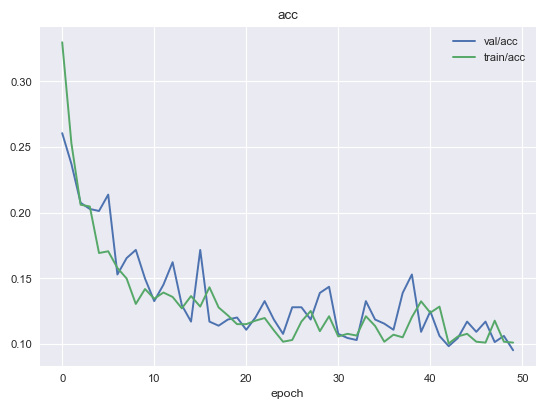

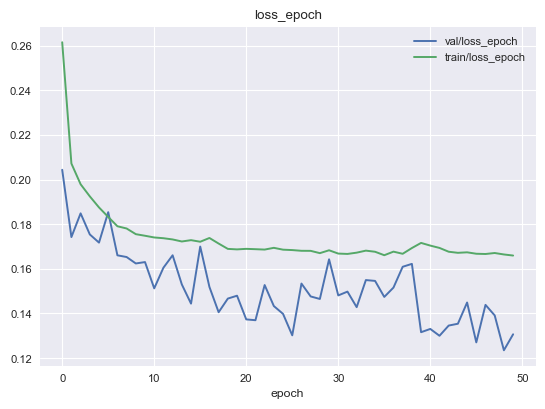

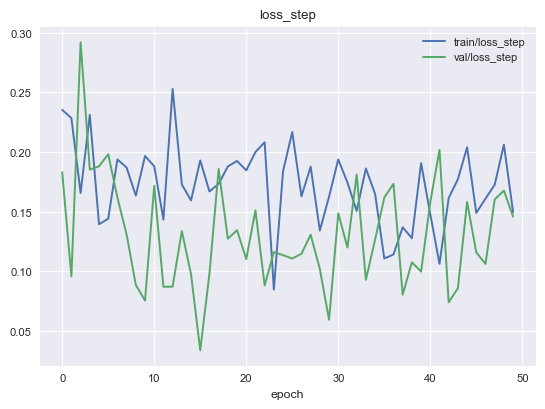

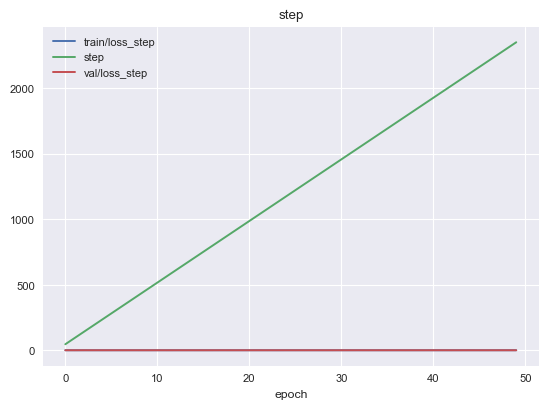

In [32]:
epoch_steps = int(len(ds_trainval)*0.7//batch_size)
pl_model = PLSKMSErank(c_in=c_in, epoch_steps=epoch_steps, max_epochs=max_epochs, depth=3, hs=64)


model = PLSKWrapper(pl_model, verbose=verbose, max_epochs=max_epochs)
if verbose: print(model)
df_res = eval_ranking(model, ds_trainval, ds_test)
df_res2 = analyze_dfres(df_res)


### PL Direct classifier


In [33]:

class HSModel3d(nn.Module):
    def __init__(self, c_in, hs, dropout=0, depth=2):
        super().__init__()
        self.preconv = nn.Sequential(
            nn.Conv2d(c_in[1], hs*4, (1, 2)),
        )

        layers = [nn.BatchNorm1d(hs*4, affine=False)]
        for i in range(depth+1):
            if (i>0) and (i<depth):
                layers.append(InceptionBlock(hs*4, hs, conv_dropout=dropout))
            elif i==0: # first layer
                if depth==0: 
                    layers.append(InceptionBlock(hs*4, 1))
                else:
                    layers.append(InceptionBlock(hs*4, hs, conv_dropout=dropout))
            else: # last layer
                layers.append(nn.Conv1d(hs*4, 1, 1))
        self.conv = nn.Sequential(*layers)
        
        n = c_in[0]
        self.head = nn.Sequential(
            LinBnDrop(n, n, p=dropout),
            LinBnDrop(n, n, p=dropout),
            nn.Linear(n, 1),  
        )

    def forward(self, x):
        x = x.float()
        if x.ndim==4:
            x = x.squeeze(3)
        x = rearrange(x, 'b l h v -> b h l v')
        x = self.preconv(x)
        x = rearrange(x, 'b h l v -> b h (l v)')
        x = self.conv(x)
        x = rearrange(x, 'b l h -> b (l h)')
        return self.head(x).squeeze(1)


In [34]:
from src.helpers.sklearn_lightning import PLSKWrapper, PLSKBase
from torchmetrics.functional import accuracy

class PLSKDirect(PLSKBase):
    def __init__(self, c_in, dropout=0, hs=32, depth=2, **kwargs):
        super().__init__(**kwargs)

        self.model = HSModel3d(c_in, hs, dropout)

    def forward(self, x):
        return self.model(x)



In [35]:
# set labels
ds2proxy = ranking_truth_telling
proxy2label = undo_ranked_truth_telling

# unit test labels
y_val1 = ds2proxy(ds_val)
y1 = proxy2label(y_val1, ds_val)
np.testing.assert_array_equal(y1, ds_val['label_true_base'], err_msg="undo_distance_truth_telling failed")
# assert (y1 == ds_val['label_true_base']).all()


In [36]:
ds_train, ds_val = train_test_split_ds(ds_trainval, test_size=0.3)
X_val, y_val_proxy = ds2xy(ds_val)
c_in = X_val.shape[1:]
c_in


torch.Size([14, 2559, 2])

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type      | Params
------------------------------------
0 | model | HSModel3d | 719 K 
------------------------------------
719 K     Trainable params
0         Non-trainable params
719 K     Total params
2.880     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |          | 0/? [00:00<?, ?it/s]

,roc_auc,improvement,acc,n,in_dist_adapter,in_dist_probe,balance,balance_proxy,roc_auc_adapter,roc_auc_base
hans,0.937611,0.122995,0.835821,67,True,True,0.492537,0.701493,0.722816,0.814617
super_glue:axg,0.988165,0.030952,0.966527,239,True,True,0.497908,0.355649,0.957213,0.853361
amazon_polarity,1.0,0.015897,0.988764,89,True,True,0.561798,0.94382,0.96359,0.984103
super_glue:rte,0.916088,0.009259,0.892857,84,True,True,0.571429,0.833333,0.846065,0.906829
glue:qnli,0.936455,0.006689,0.847059,85,True,True,0.458824,0.835294,0.693423,0.929766
sst2,0.886856,-0.071816,0.87013,77,True,True,0.532468,0.844156,0.842818,0.958672
super_glue:boolq,0.620486,-0.304943,0.55618,534,False,False,0.453184,0.235955,0.912968,0.925429
imdb,0.114921,-0.847782,0.123596,534,False,False,0.486891,0.082397,0.962704,0.92952


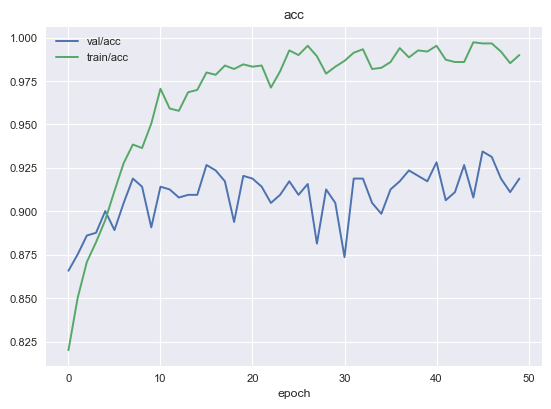

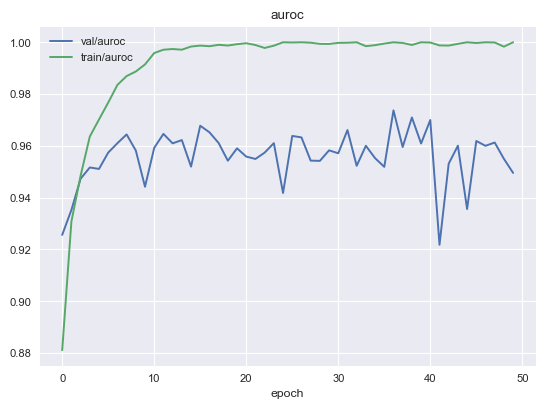

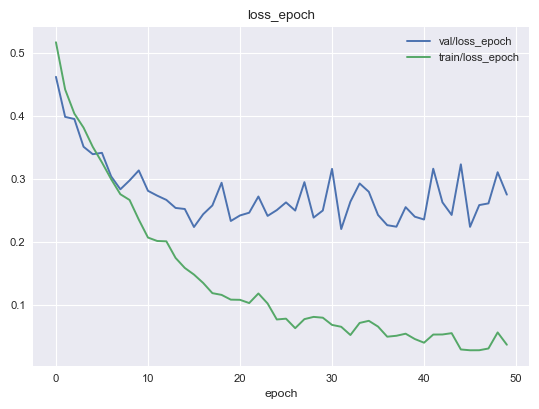

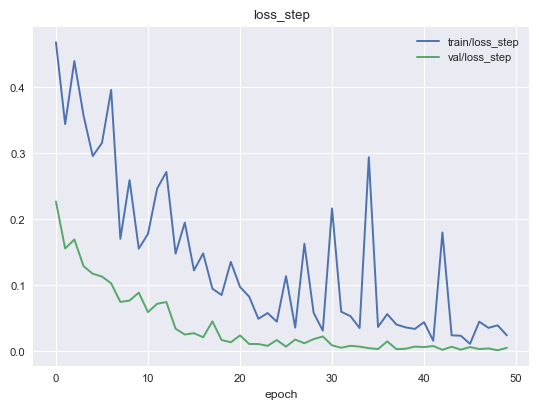

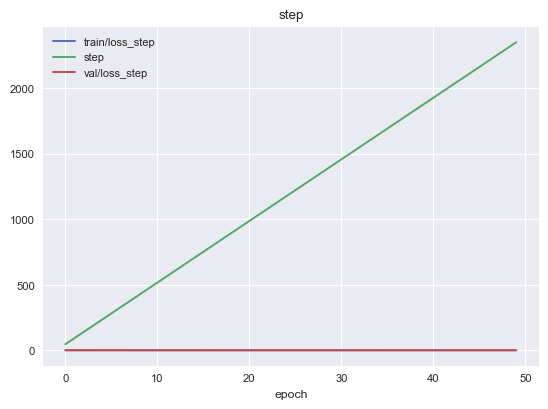

In [37]:
epoch_steps = int(len(ds_trainval)*0.7//batch_size)
pl_model = PLSKDirect(c_in=c_in, epoch_steps=epoch_steps, max_epochs=max_epochs)
if verbose: print(model)
model = PLSKWrapper(pl_model, verbose=verbose, max_epochs=max_epochs)
df_res = eval_ranking(model, ds_trainval, ds_test)
df_res2 = analyze_dfres(df_res)


### Bool ranking


In [44]:
from src.helpers.sklearn_lightning import PLSKWrapper, PLSKBase
from torchmetrics.functional import accuracy

class PLSKBoolRank(PLSKBase):
    def __init__(self, c_in, dropout=0, hs=32, depth=2, **kwargs):
        super().__init__(**kwargs)

        self.model = HSModel2d(c_in, hs, dropout)

    def forward(self, x):
        return self.model(x)

    def _step(self, batch, batch_idx, stage='train'):
        x, y = batch
        x0 = x[..., 0]
        x1 = x[..., 1]
        ypred0 = self(x0)
        ypred1 = self(x1)

        y_probs = F.sigmoid(ypred1-ypred0+0.5)
        y_cls = y_probs > 0.5
        
        if stage=='pred':
            return y_probs

        ranking_y = (y>0)*2-1 # from 0,1 to -1,1
        loss = F.margin_ranking_loss(ypred0, ypred1, ranking_y, margin=1)
        
        y_cls = ypred1>ypred0 # switch2bool(ypred1-ypred0)
        self.log(f"{stage}/acc", accuracy(y_cls, y>0.5, "binary"), on_epoch=True, on_step=False)
        self.log(f"{stage}/loss", loss, on_epoch=True, on_step=True, prog_bar=True)
        self.log(f"{stage}/n", len(y), on_epoch=True, on_step=False, reduce_fx=torch.sum)
        return loss


In [45]:
ds_train, ds_val = train_test_split_ds(ds_trainval, test_size=0.3)
X_val, y_val_proxy = ds2xy(ds_val)
c_in = X_val.shape[1:]
c_in


torch.Size([14, 2559, 2])

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type      | Params
------------------------------------
0 | model | HSModel2d | 546 K 
------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |          | 0/? [00:00<?, ?it/s]

,roc_auc,improvement,acc,n,in_dist_adapter,in_dist_probe,balance,balance_proxy,roc_auc_adapter,roc_auc_base
hans,0.928699,0.114082,0.850746,67,True,True,0.492537,0.701493,0.722816,0.814617
super_glue:rte,0.958333,0.051505,0.904762,84,True,True,0.571429,0.833333,0.846065,0.906829
super_glue:axg,0.99965,0.042437,0.987448,239,True,True,0.497908,0.355649,0.957213,0.853361
glue:qnli,0.96767,0.037904,0.847059,85,True,True,0.458824,0.835294,0.693423,0.929766
amazon_polarity,0.998974,0.014872,0.977528,89,True,True,0.561798,0.94382,0.96359,0.984103
imdb,0.962296,-0.000407,0.91573,534,False,False,0.486891,0.082397,0.962704,0.92952
sst2,0.954607,-0.004065,0.883117,77,True,True,0.532468,0.844156,0.842818,0.958672
super_glue:boolq,0.794846,-0.130583,0.692884,534,False,False,0.453184,0.235955,0.912968,0.925429


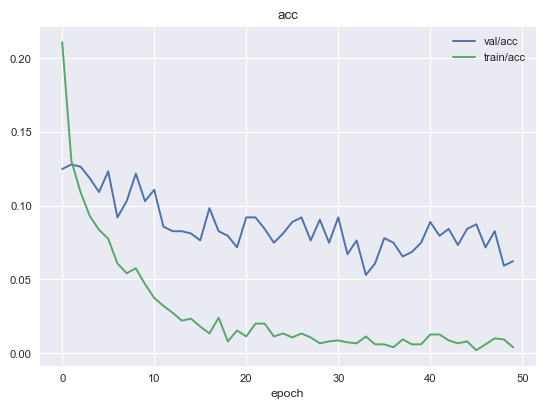

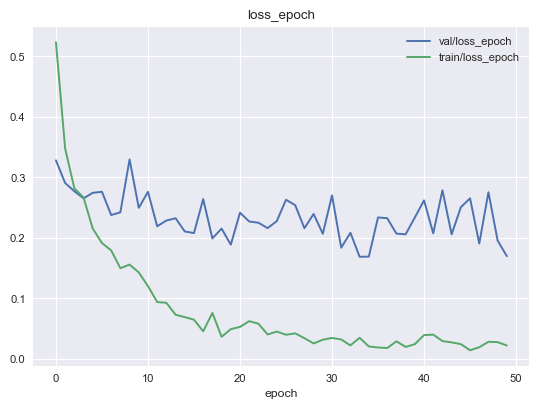

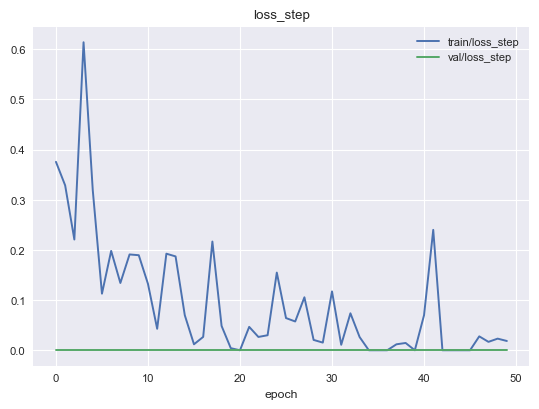

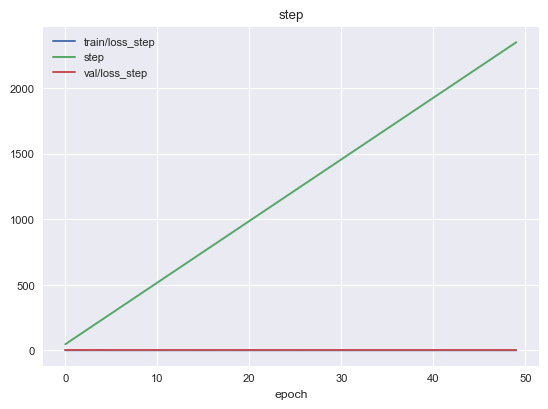

In [46]:
epoch_steps = int(len(ds_trainval)*0.7//batch_size)
pl_model = PLSKBoolRank(c_in=c_in, epoch_steps=epoch_steps, max_epochs=max_epochs, depth=3, hs=64)


model = PLSKWrapper(pl_model, verbose=verbose, max_epochs=max_epochs)
if verbose: print(model)
df_res = eval_ranking(model, ds_trainval, ds_test)
df_res2 = analyze_dfres(df_res)


### CCS

In [85]:
from src.helpers.sklearn_lightning import PLSKWrapper, PLSKBase
from torchmetrics.functional import accuracy

def ccs_loss(p_neg, p_pos):
    consistency_losses = (p_pos - (1 - p_neg)) ** 2
    confidence_losses = torch.min(torch.stack((p_pos, p_neg), dim=-1), dim=-1).values ** 2
    return torch.mean(consistency_losses + confidence_losses)

class PLSKCCS(PLSKBase):
    def __init__(self, c_in, dropout=0, hs=32, depth=2, **kwargs):
        super().__init__(**kwargs)
        self.model = nn.Sequential(
            nn.Linear(np.prod(c_in), 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).squeeze(1)

    def _step(self, batch, batch_idx, stage='train'):
        x, y = batch
        x = rearrange(x, 'b l h v -> b (l h v)').float()
        yb = y>0.5
        ypred = self(x)
        if stage=='pred':
            return ypred

        p_neg = ypred[~yb].mean()
        p_pos = ypred[yb].mean()
        loss = ccs_loss(p_neg, p_pos)
        assert torch.isfinite(loss)

        y_cls = ypred>0.5 # switch2bool(ypred1-ypred0)
        self.log(f"{stage}/acc", accuracy(y_cls, y>0.5, "binary"), on_epoch=True, on_step=False)
        self.log(f"{stage}/loss", loss, on_epoch=True, on_step=True, prog_bar=True)
        self.log(f"{stage}/n", len(y), on_epoch=True, on_step=False, reduce_fx=torch.sum)
        return loss


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 71.7 K
-------------------------------------
71.7 K    Trainable params
0         Non-trainable params
71.7 K    Total params
0.287     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |          | 0/? [00:00<?, ?it/s]

,roc_auc,improvement,acc,n,in_dist_adapter,in_dist_probe,balance,balance_proxy,roc_auc_adapter,roc_auc_base
super_glue:boolq,0.281261,-0.644168,0.235955,534,False,False,0.453184,0.235955,0.912968,0.925429
hans,0.14795,-0.666667,0.313433,67,True,True,0.492537,0.701493,0.722816,0.814617
super_glue:rte,0.094329,-0.8125,0.154762,84,True,True,0.571429,0.833333,0.846065,0.906829
glue:qnli,0.082497,-0.847269,0.164706,85,True,True,0.458824,0.835294,0.693423,0.929766
imdb,0.108352,-0.854351,0.093633,534,False,False,0.486891,0.082397,0.962704,0.92952
sst2,0.057588,-0.901084,0.077922,77,True,True,0.532468,0.844156,0.842818,0.958672
super_glue:axg,0.041106,-0.916106,0.066946,239,True,True,0.497908,0.355649,0.957213,0.853361
amazon_polarity,0.032308,-0.951795,0.05618,89,True,True,0.561798,0.94382,0.96359,0.984103


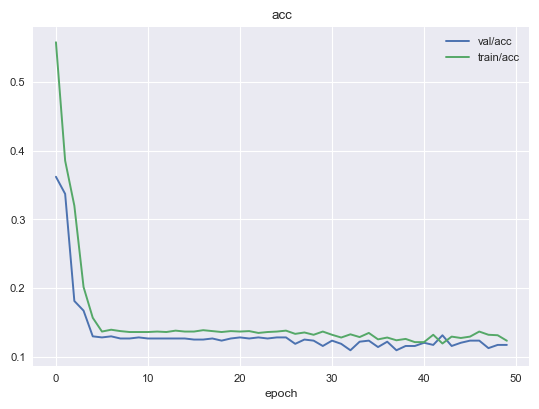

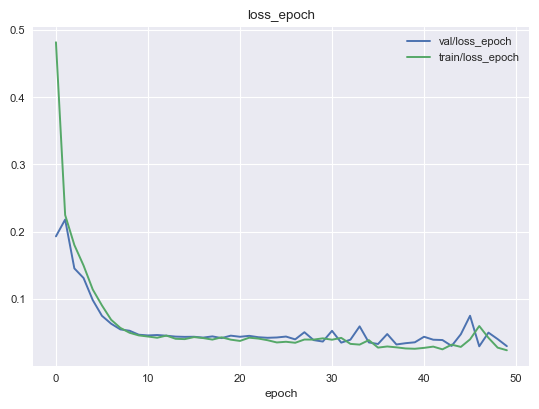

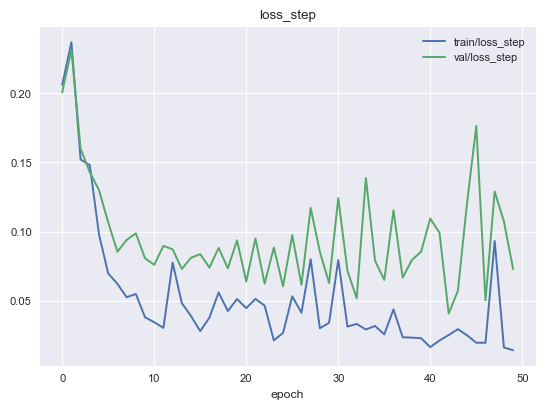

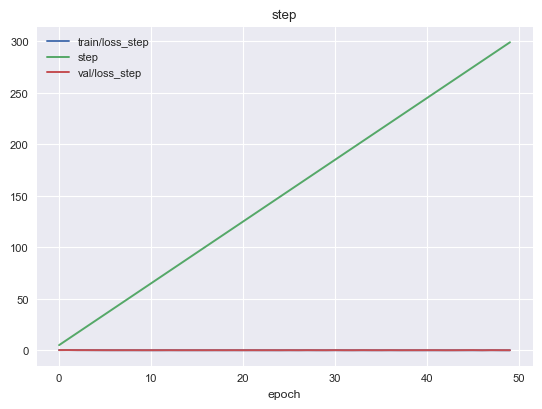

In [88]:
batch_size = 256
epoch_steps = int(len(ds_trainval)*0.7//batch_size)
pl_model = PLSKCCS(c_in=c_in, epoch_steps=epoch_steps, max_epochs=max_epochs, depth=3, hs=64, lr=1e-4)


model = PLSKWrapper(pl_model, verbose=verbose, max_epochs=max_epochs, batch_size=batch_size)
if verbose: print(model)
df_res = eval_ranking(model, ds_trainval, ds_test)
df_res2 = analyze_dfres(df_res)


In [97]:
# CSS doesn't know the direction, so sometimes we need to flip it
df_res2['roc_auc'] = 1-df_res2['roc_auc']
df_res2['improvement'] = df_res2['roc_auc'] - df_res2['roc_auc_adapter']
df_res2.sort_values('improvement', ascending=False)


,roc_auc,improvement,acc,n,in_dist_adapter,in_dist_probe,balance,balance_proxy,roc_auc_adapter,roc_auc_base
glue:qnli,0.917503,0.22408,0.164706,85,True,True,0.458824,0.835294,0.693423,0.929766
hans,0.85205,0.129234,0.313433,67,True,True,0.492537,0.701493,0.722816,0.814617
sst2,0.942412,0.099593,0.077922,77,True,True,0.532468,0.844156,0.842818,0.958672
super_glue:rte,0.905671,0.059606,0.154762,84,True,True,0.571429,0.833333,0.846065,0.906829
amazon_polarity,0.967692,0.004103,0.05618,89,True,True,0.561798,0.94382,0.96359,0.984103
super_glue:axg,0.958894,0.001681,0.066946,239,True,True,0.497908,0.355649,0.957213,0.853361
imdb,0.891648,-0.071056,0.093633,534,False,False,0.486891,0.082397,0.962704,0.92952
super_glue:boolq,0.718739,-0.194229,0.235955,534,False,False,0.453184,0.235955,0.912968,0.925429


### Conformal

In [54]:

import numpy as np
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB, MultinomialNB
from mapie.classification import MapieClassifier



In [83]:
class MapieClassifier2(MapieClassifier):

    def fit(self, X_train, y_train, sample_weight=None, X_val=None, y_val=None, **kwargs):
        X_train = rearrange(X_train, 'b l h v -> b (l h v)')
        return super().fit(X_train.numpy(), y_train.numpy(), sample_weight, **kwargs)

    def predict_proba(self, X):
        X = rearrange(X, 'b l h v -> b (l h v)').numpy()
        return torch.from_numpy(super().predict(X)).float()


In [98]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced',)
model = MapieClassifier2(estimator=clf, 
                        # cv="prefit",
                        method="score",                        
                        )

df_res = eval_ranking(model, ds_trainval, ds_test)
df_res2 = analyze_dfres(df_res)


,roc_auc,improvement,acc,n,in_dist_adapter,in_dist_probe,balance,balance_proxy,roc_auc_adapter,roc_auc_base
super_glue:axg,0.953922,-0.003291,0.953975,239,True,True,0.497908,0.355649,0.957213,0.853361
amazon_polarity,0.977179,-0.006923,0.977528,89,True,True,0.561798,0.94382,0.96359,0.984103
hans,0.807041,-0.007576,0.80597,67,True,True,0.492537,0.701493,0.722816,0.814617
glue:qnli,0.876533,-0.053233,0.870588,85,True,True,0.458824,0.835294,0.693423,0.929766
sst2,0.883469,-0.075203,0.883117,77,True,True,0.532468,0.844156,0.842818,0.958672
super_glue:rte,0.819444,-0.087384,0.821429,84,True,True,0.571429,0.833333,0.846065,0.906829
super_glue:boolq,0.635387,-0.290042,0.644195,534,False,False,0.453184,0.235955,0.912968,0.925429
imdb,0.247066,-0.715637,0.247191,534,False,False,0.486891,0.082397,0.962704,0.92952
